In [1]:
import pandas as pd
import numpy as np

# Ví dụ dữ liệu
df = pd.DataFrame({
    "order_id": [1,2,3,4,5],
    "price": [45000, 120000, 80000, 250000, 70000],
    "freight": [15000, 20000, 30000, 50000, 25000],
    "converted": [1, 1, 0, 1, 0]  # 1: mua, 0: bỏ
})

# Tính tỷ lệ Freight/Price
df["fp_ratio"] = df["freight"] / df["price"]

# Phân tầng theo ngưỡng
bins = [0, 0.1, 0.15, 0.3, np.inf]
labels = ["<10%", "10–15%", "15–30%", ">30%"]
df["fp_bucket"] = pd.cut(df["fp_ratio"], bins=bins, labels=labels, right=True)

# Tóm tắt tỷ lệ chuyển đổi theo tầng
summary = df.groupby("fp_bucket")["converted"].agg([
    ("count_orders", "count"),
    ("conversion_rate", "mean")
]).reset_index()

print(df[["order_id","price","freight","fp_ratio","fp_bucket","converted"]])
print(summary)

   order_id   price  freight  fp_ratio fp_bucket  converted
0         1   45000    15000  0.333333      >30%          1
1         2  120000    20000  0.166667    15–30%          1
2         3   80000    30000  0.375000      >30%          0
3         4  250000    50000  0.200000    15–30%          1
4         5   70000    25000  0.357143      >30%          0
  fp_bucket  count_orders  conversion_rate
0      <10%             0              NaN
1    10–15%             0              NaN
2    15–30%             2         1.000000
3      >30%             3         0.333333


C:\Users\sonvuuu\AppData\Local\Temp\ipykernel_20860\3855942635.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("fp_bucket")["converted"].agg([


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = df[["fp_ratio", "price", "freight"]]
y = df["converted"]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression())
])

pipe.fit(X, y)
coef = pipe.named_steps["logit"].coef_[0]
features = X.columns.tolist()

for f, c in zip(features, coef):
    print(f"{f}: {c:.3f}")

fp_ratio: -0.835
price: 0.316
freight: -0.244


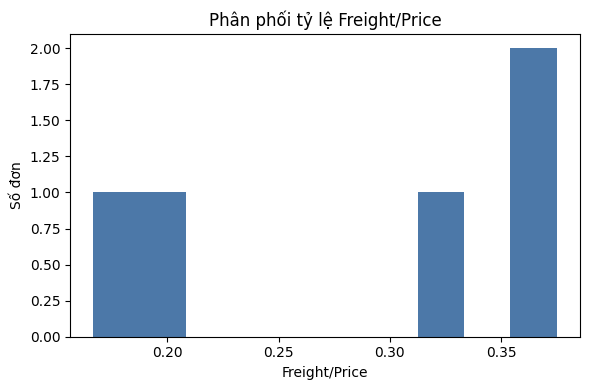

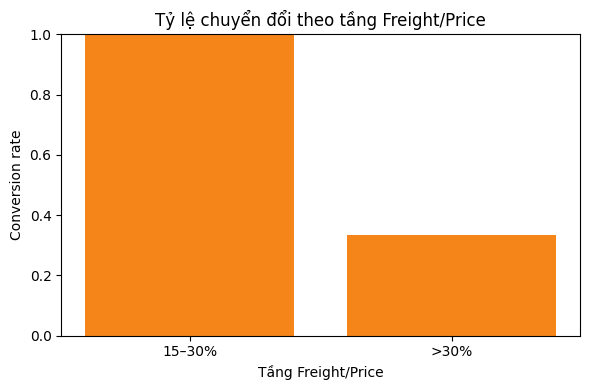

In [3]:
import matplotlib.pyplot as plt

# Histogram tỷ lệ Freight/Price
plt.figure(figsize=(6,4))
plt.hist(df["fp_ratio"], bins=10, color="#4c78a8")
plt.title("Phân phối tỷ lệ Freight/Price")
plt.xlabel("Freight/Price")
plt.ylabel("Số đơn")
plt.tight_layout()
plt.show()

# Conversion theo bucket
plt.figure(figsize=(6,4))
plt.bar(summary["fp_bucket"].astype(str), summary["conversion_rate"], color="#f58518")
plt.title("Tỷ lệ chuyển đổi theo tầng Freight/Price")
plt.xlabel("Tầng Freight/Price")
plt.ylabel("Conversion rate")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.spatial import cKDTree
import numpy as np

## Xác định khách
df1 = customers[["customer_id", "customer_zip_code_prefix"]].merge(geolocation, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")
df1 = df1[["customer_id", "lat", "long"]]
df1 = df1.rename(columns={"lat": "customer_lat", "long": "customer_long"})
df1 = orders[["order_id", "customer_id"]].merge(df1, on="customer_id", how="left")
df1 = df1.dropna(subset=['customer_lat','customer_long'])

## Xác định seller
df2 = sellers[["seller_id", "seller_zip_code_prefix"]].merge(geolocation, left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")
df2 = df2[["seller_id", "lat", "long"]]
df2 = df2.rename(columns={"lat": "seller_lat", "long": "seller_long"})
df2 = order_items[["order_id", "seller_id"]].merge(df2, on="seller_id", how="left")
df2[['seller_id','seller_lat','seller_long']].drop_duplicates()
df2 = df2.dropna(subset=['seller_lat','seller_long'])

# Chuyển tọa độ khách và seller sang radian
customers_coords = np.radians(df1[['customer_lat','customer_long']].values)
sellers_coords = np.radians(df2[['seller_lat','seller_long']].values)

# Tạo KDTree cho seller
tree = cKDTree(sellers_coords)

# Tìm seller gần nhất cho từng khách
dist, idx = tree.query(customers_coords, k=1)  # k=1 nghĩa là seller gần nhất

# Chuyển khoảng cách từ radian sang km
R = 6371
df1['nearest_seller_km'] = dist * R

bins = [-1, 100, 500, 1000, np.inf]
labels = [1, 2, 3, 4]  # duy nhất
df1['distance_group'] = pd.cut(df1['nearest_seller_km'], bins=bins, labels=labels)
df1['distance_group'] = df1['distance_group'].replace({4: 3})

df1 = df1[["customer_id", "order_id", "nearest_seller_km", "distance_group"]]

customers = customers.merge(df1[["customer_id", "nearest_seller_km", "distance_group"]], on="customer_id", how="left")